Notebook correspondant à la section 3.1 du rapport.
Implémentation de résolution numérique approchée des 2 équations couplées du mouvement de précession :
\begin{equation}
\left\{
    \begin{aligned}
        \frac{dM_x}{dt} &= \omega M_y \\
        \frac{dM_y}{dt} &= -\omega M_x
    \end{aligned}
\right.
\end{equation}
à l'aide de la méthode de descente de gradients sur la fonction d'erreur


In [1]:
#imports
from numpy import pi, cos, sin, dot, zeros, linspace, arange, matmul, concatenate
from numpy.random import randn

Paramètres du modèle

In [2]:
#nombre de coefficients de Fourier ajustables
H = 10
H_range = arange(H) +1

# nombre de points pour la variable indépendante
N = 100
T = linspace(0,1,N)

Paramètres du problème

In [3]:
W = 2*pi #pulsation
V0 = 1 #vitesse initiale

Calculs des vecteurs des cosinus et sinus qui seront souvent utilisés

In [4]:
#matrice de coefficients (m*W*T[i]) de taille NxM
#avec première coordonnée i, et deuxème m
m_w_T = W*matmul(T.reshape((N,1)), H_range.reshape((1,H)))
cos = cos(m_w_T)
sin = sin(m_w_T)

Définition du gradient

In [5]:
def calcGrad(A,B, H, H_range, N, cos, sin) :
    #calcule le gradient de l'erreur par rapport aux
    #2 vecteurs de paramètres A et B
    grad_A = zeros((H))
    grad_B = zeros((H))

    for i in range(N) :
        #valeurs de vx et vy à l'instant T[i]
        vx = V0 + dot(A, cos[i]-1) + dot(B, sin[i])
        vy = - dot(A, sin[i]) + dot(B, cos[i]-1)

        #valeurs des dérivées de vx et vy à l'instant T[i]
        dvx = W*(-dot(H_range*A, sin[i]) + dot(H_range*B, cos[i]))
        dvy = W*(-dot(H_range*A, cos[i]) - dot(H_range*B, sin[i]))

        #différences
        ex = dvx - W*vy
        ey = dvy + W*vx

        #on incrémente les gradients
        #pour A
        dex_dA = W*(1-H_range)*sin[i]
        dey_dA = W*((1-H_range)*cos[i]-1)
        grad_A += ex*dex_dA + ey*dey_dA
        #pour B
        dex_dB = W*((H_range-1)*cos[i]+1)
        dey_dB = W*(1-H_range)*sin[i]
        grad_B += ex*dex_dB + ey*dey_dB

    return grad_A, grad_B

Définition de l'erreur

In [6]:
def calcErreur(A,B, H_range, N, cos, sin)  :

    erreur = 0
    for i in range(N) :
        #valeurs de vx et vy à l'instant T[i]
        vx = V0 + dot(A, cos[i]-1) + dot(B, sin[i])
        vy = - dot(A, sin[i]) + dot(B, cos[i]-1)

        #valeurs des dérivées de vx et vy à l'instant T[i]
        dvx = W*(-dot(H_range*A, sin[i]) + dot(H_range*B, cos[i]))
        dvy = W*(-dot(H_range*A, cos[i]) - dot(H_range*B, sin[i]))

        #différences
        ex = dvx - W*vy
        ey = dvy + W*vx

        erreur += ex**2 + ey**2

    return erreur/2

Calcul matriciel du gradient

In [7]:
d = zeros(2*H)
for l in range(1,H+1) :
    for i in range(N) :
        d[l-1] += (1-l)*cos[i,l-1]-1
        d[l-1+H] += (1-l)*sin[i,l-1]

d*=W**2*V0


mat = zeros((2*H,2*H))

for l in range(1,H+1) :
    for m in range(1,H+1) :
        for i in range(N) :
            mat[l-1,m-1] += (1-l)*(1-m)*sin[i,m-1]*sin[i,l-1]
            mat[l-1,m-1] += ((1-l)*cos[i,l-1]-1)*((1-m)*cos[i,m-1]-1)

            mat[l-1,m-1+H] += (1-l)*sin[i,l-1]*((m-1)*cos[i,m-1]+1)
            mat[l-1,m-1+H] += (1-m)*sin[i,m-1]*((1-l)*cos[i,l-1]-1)

            mat[l-1+H,m-1] += ((l-1)*cos[i,l-1]+1)*(1-m)*sin[i,m-1]
            mat[l-1+H,m-1] += (1-l)*sin[i,l-1]*((1-m)*cos[i,m-1]-1)

            mat[l-1+H,m-1+H] += ((l-1)*cos[i,l-1]+1)*((m-1)*cos[i,m-1]+1)
            mat[l-1+H,m-1+H] += (1-l)*(1-m)*sin[i,m-1]*sin[i,l-1]

mat *= W**2



def calcGrad_mat(A, B, H, mat, d) :
    P = concatenate((A,B))
    G = matmul(mat, P) + d
    return G[:H], G[H:]

Paramètres d'apprentissage

In [8]:
alpha = 6.0906090609060915e-06 #taux d'apprentissage pour la descente de gradients
epochs = 6000 #nombre d'itération

#initialisation des coefficients
A = randn((H))
B = randn((H))

Entraînement

In [9]:
E = [] #evolution de l'erreur

for k in range(epochs) :
    if k%(epochs//10)==0 :
        print("\nCoefficients après",k,"itérations :\n",A,"\n", B)
    
    if k%(epochs//100)==0 :
        E.append(calcErreur(A,B, H_range, N, cos, sin))

    grad_A, grad_B = calcGrad_mat(A, B, H, mat, d)
    A -= alpha*grad_A
    B -= alpha*grad_B


E.append(calcErreur(A,B, H_range, N, cos, sin))


Coefficients après 0 itérations :
 [ 0.02976545  1.4211507   1.60707509  0.76002078 -0.12596394  0.97887652
  0.86779915 -1.74525716  0.89838837 -0.15601449] 
 [ 1.30890486 -1.29106348 -0.95730345 -1.09709165  1.08604041  1.06188703
 -0.55779627 -0.85174771  0.15548412 -2.13802313]

Coefficients après 600 itérations :
 [ 9.87347771e-01  6.14212820e-03  1.09076577e-03  4.48407276e-04
  2.39644977e-04  1.45623528e-04  9.44962356e-05  6.17875953e-05
  3.34883977e-05 -1.19519912e-04] 
 [ 0.01374831 -0.00716198 -0.00158975 -0.00093029 -0.00077493 -0.00078527
 -0.00091756 -0.00124805 -0.00222517 -0.01673684]

Coefficients après 1200 itérations :
 [ 9.99891467e-01  5.26915014e-05  9.35954545e-06  3.84955850e-06
  2.05925481e-06  1.25349858e-06  8.16213957e-07  5.38154122e-07
  3.02338248e-07 -9.09135347e-07] 
 [ 1.18157080e-04 -6.11969902e-05 -1.33681992e-05 -7.67253476e-06
 -6.28528629e-06 -6.29219307e-06 -7.29238087e-06 -9.86608576e-06
 -1.75297996e-05 -1.31558173e-04]

Coefficients après 

Affichage des résultats

In [10]:
print()
print("Coefficients finaux après",epochs,"itérations :",A,B)


Coefficients finaux après 6000 itérations : [1.00000000e+00 2.26827368e-15 5.45775800e-16 2.41453264e-16
 1.29609068e-16 8.19947601e-17 5.76357660e-17 3.94688683e-17
 3.04777319e-17 2.63859807e-17] [ 3.50023790e-21 -1.75567521e-21 -3.48578781e-22 -1.75332141e-22
 -1.25852948e-22 -1.12863951e-22 -1.20463112e-22 -1.53780793e-22
 -2.62611182e-22 -1.91921960e-21]


Affichage graphique de l'erreur

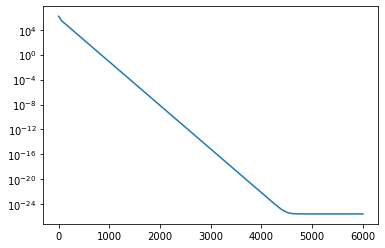

In [11]:
from matplotlib.pyplot import plot, show, yscale, savefig

plot([epochs//100*k for k in range(101)], E)
yscale('log')
#savefig("Erreur_2_DG.jpg")
show()

In [12]:
print(E[int(6000/epochs*100)])

2.5912284229086244e-26


Affichage des coefficients trouvés

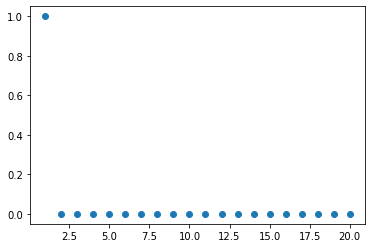

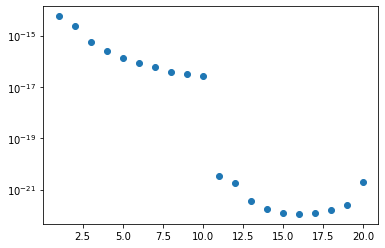

In [13]:
from matplotlib.pyplot import scatter, show, yscale, savefig

P = concatenate((A,B))
#erreur relative sur le premier coefficient
#valeurs théoriques :
P_th = zeros((2*H))
P_th[0] = 1

erreur = abs(P-P_th)

scatter(range(1, 2*H+1), P)
show()

scatter(range(1, 2*H+1), erreur)
yscale('log')
show()
